In [64]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [65]:
# Step 1: Load the CSV dataset
df = pd.read_csv('thermal_properties_data.csv')

In [66]:
# Extract features from the dataset
X = df[[
    'Thermal Conductivity (W/m*K)', 
    'Thermal Diffusivity (mm2/s)', 
    'Specific Heat Capacity (J/kg*K)', 
    'Volumetric Specific Heat (MJ/m³K)', 
    'Thermal Effusivity (Ws0.5/(m2K))', 
    'Material Density (kg/m3)'
]].values

In [67]:
# Step 2: Normalize the input features (mean = 0, std = 1)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [68]:
# Step 3: Build the MLP Neural Network
def build_mlp():
    """Build a simple MLP that takes 6 inputs and outputs 2 values (Durability, Price)"""
    
    inputs = Input(shape=(6,))  # 6 input features
    
    # Hidden layers
    x = Dense(64, activation='relu')(inputs)
    x = Dense(32, activation='relu')(x)
    
    # Output 2 neurons (Durability, Price)
    outputs = Dense(2, activation='sigmoid')(x)  # Sigmoid to keep them between 0 and 1
    
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])  # Mean squared error loss
    return model

In [69]:
# Step 4: Build and compile the model
model = build_mlp()

# Print model summary to see architecture
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 6)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 64)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,594 (10.13 KB)

 Trainable params: 2,594 (10.13 KB)

 Non-trainable params: 0 (0.00 B)

In [70]:
# Step 5: Split the data into training and testing sets
X_train, X_test = train_test_split(X_scaled, test_size=0.2, random_state=42)

In [71]:
# Step 6: Train the model
# Initialize random targets for 'Durability' and 'Price' for training purposes
initial_targets = np.random.rand(X_train.shape[0], 2)  # Random initial targets for the two unknowns

history = model.fit(X_train, initial_targets,  # Train to predict 2 output labels
                    epochs=20,                # Number of epochs
                    batch_size=128,           # Batch size
                    validation_split=0.2)    # Validate on unseen portion of training data

Epoch 1/20
579/579 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0831 - mae: 0.2491 - val_loss: 0.0835 - val_mae: 0.2501
Epoch 2/20
579/579 ━━━━━━━━━━━━━━━━━━━━ 1s 991us/step - loss: 0.0831 - mae: 0.2493 - val_loss: 0.0833 - val_mae: 0.2499
Epoch 3/20
579/579 ━━━━━━━━━━━━━━━━━━━━ 1s 950us/step - loss: 0.0828 - mae: 0.2488 - val_loss: 0.0833 - val_mae: 0.2499
Epoch 4/20
579/579 ━━━━━━━━━━━━━━━━━━━━ 1s 940us/step - loss: 0.0826 - mae: 0.2485 - val_loss: 0.0833 - val_mae: 0.2499
Epoch 5/20
579/579 ━━━━━━━━━━━━━━━━━━━━ 1s 942us/step - loss: 0.0828 - mae: 0.2490 - val_loss: 0.0833 - val_mae: 0.2498
Epoch 6/20
579/579 ━━━━━━━━━━━━━━━━━━━━ 1s 974us/step - loss: 0.0828 - mae: 0.2489 - val_loss: 0.0833 - val_mae: 0.2499
Epoch 7/20
579/579 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0826 - mae: 0.2483 - val_loss: 0.0833 - val_mae: 0.2499
Epoch 8/20
579/579 ━━━━━━━━━━━━━━━━━━━━ 1s 955us/step - loss: 0.0827 - mae: 0.2488 - val_loss: 0.0833 - val_mae: 0.2499
Epoch 9/20
579/579 ━━━━━━━━━━━━━━━━━━━━ 1s 9

In [72]:
# Step 7: Generate new synthetic 'Durability' and 'Price' for all samples
# Use the trained model to predict Durability and Price
predicted_durability_price = model.predict(X_scaled)

# Separate the columns for Durability and Price
durability = predicted_durability_price[:, 0]  # First output of the MLP
price = predicted_durability_price[:, 1]  # Second output of the MLP

# Normalize durability and price to range 0-100 for interpretability
min_max_scaler = MinMaxScaler(feature_range=(0, 100))
durability_normalized = min_max_scaler.fit_transform(durability.reshape(-1, 1))
price_normalized = min_max_scaler.fit_transform(price.reshape(-1, 1))

3615/3615 ━━━━━━━━━━━━━━━━━━━━ 1s 393us/step


In [73]:
# Add the new columns to the existing DataFrame
df['Durability (d)'] = durability_normalized
df['Price (c) ($/m^3)'] = price_normalized

In [74]:
# Save the dataset to a CSV file
df.to_csv('enhanced_materials_dataset.csv', index=False)

In [75]:
# Print a sample of the enhanced dataset
print("Sample of the dataset with Durability and Price:")
df.head()

Sample of the dataset with Durability and Price:


,Material,Thermal Conductivity (W/m*K),Thermal Diffusivity (mm2/s),Specific Heat Capacity (J/kg*K),Volumetric Specific Heat (MJ/m³K),Thermal Effusivity (Ws0.5/(m2K)),Material Density (kg/m3),Durability (d),Price (c) ($/m^3)
0,1-dodecene,0.1400,0.08560,2150,1.636,478.5,761.0,54.260132,61.351807
1,abs resin (high k),0.2090,0.13000,1506,1.566,572.0,1040.0,50.268799,61.506226
2,abs resin (low k),0.1380,0.09000,1506,1.566,465.0,1040.0,50.177185,61.584229
3,acetal resin (delrin),0.2300,0.11000,1464,2.079,692.0,1420.0,45.826904,67.461914
4,acetone (propanone) (25 °C),0.1535,0.09128,2129,1.682,46.0,790.0,53.730591,61.740112


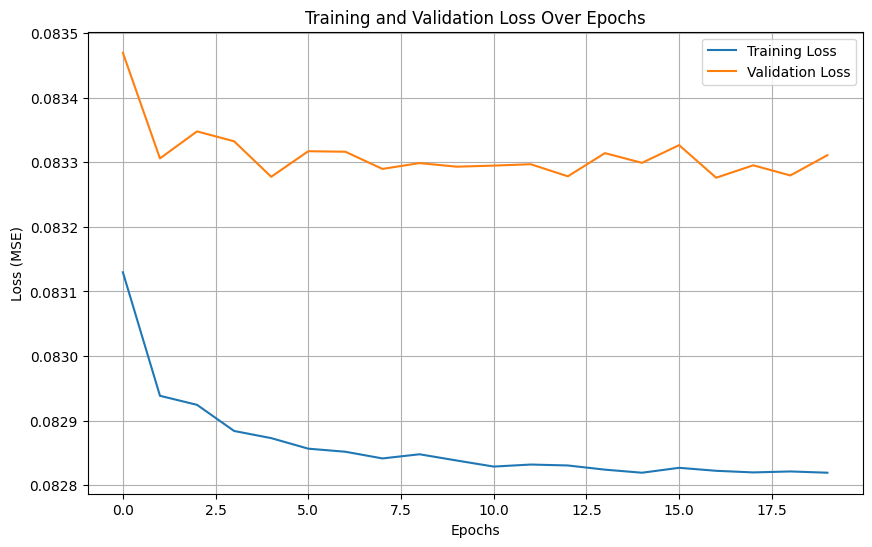

In [76]:
# Step 8: Visualize the training loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

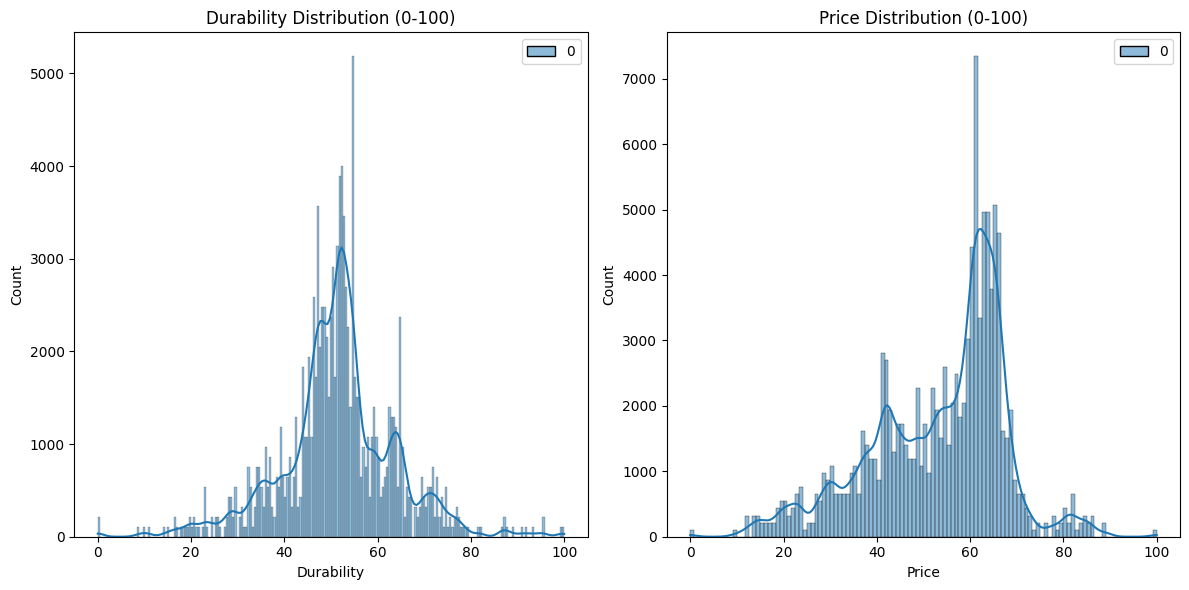

In [77]:
# Step 9: Visualize the distribution of Durability and Price
plt.figure(figsize=(12, 6))

# Durability distribution
plt.subplot(1, 2, 1)
sns.histplot(durability_normalized, kde=True, color='skyblue')
plt.title('Durability Distribution (0-100)')
plt.xlabel('Durability')

# Price distribution
plt.subplot(1, 2, 2)
sns.histplot(price_normalized, kde=True, color='salmon')
plt.title('Price Distribution (0-100)')
plt.xlabel('Price')

plt.tight_layout()
plt.show()